In [125]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as scs
from sklearn.preprocessing import normalize as norm
from sklearn import linear_model
import datetime
import time
from datetime import datetime , timedelta

import zipfile
import math

from csv import reader
from matplotlib.pyplot import figure
import seaborn as sns;
import re
from IPython.display import clear_output

In [126]:
list_of_companies_number = ['1080', '1113', '1221', '1229', '1243', '1388', '1431', '1472', '1694', '1769', '1865', '1907', '1956', '2028',
                           '2050', '2051', '2057', '2094', '2197', '2290', '2368', '2645', '2651', '2730', '2748', '2813', '2822', '2890', 
                           '3022', '3035', '3107', '3161', '3388', '3459', '3757', '3879', '4060', '4154', '4218', '4320', '4481', 
                            '4549', '4575', '4618', '4695', '4736', '4799', '4851', '5836', '7843', '7858', '8080', '9034', '9058', '9061',
                           '9062', '9063', '9064', '9065', '9067', '9069', '9074', '9086', '9094', '9265', '9266', '9268', '9269',
                            '9270', '9761', '10166', '10470', '10484', '10508', '10795', '10887', '11038', '11234', '11244', '11390', '11399',
                           '11583','11618','11714', '11867', '11869', '11946', '12059', '12098', '12255', '12327', '12417', '12456', '12534',
                           '12552', '12713', '13003', '13061', '13113']

In [127]:
#shape = [(nr of company, every possible timeslot from 8.00 till 16.29, bid/ask, price/volume, 5 best offers from 9.15!))]
data = np.zeros(shape = (100, 5100,2,2,10))

In [128]:
def get_k_best_offers(record, k=5):
    count = 0
    count_bid = 0
    count_ask = 0
    k_best_bids_and_asks = np.zeros(shape = (2,2,k))
    while(record[count]!='ASK'):
        count+=1
    for counter in range(1,k*2 + 1):
        #bid
        if record[count-counter]=='BID':
            continue
        try:
            k_best_bids_and_asks[0][counter%2][(counter-1)//2]=record[count-counter]
        except IndexError as err:
            k_best_bids_and_asks[0][counter%2][(counter-1)//2]=0
            print('bid', err, record)
        #ask
        try:
            k_best_bids_and_asks[1][(counter-1)%2][(counter-1)//2]=record[count+counter]
        except IndexError as err:
            k_best_bids_and_asks[1][(counter-1)%2][(counter-1)//2]=0
            print("ask", err, record)        
    return k_best_bids_and_asks

In [129]:
def get_mid_price(record): #shape = (2,2,5) (bid/ask, price/volume, best offers):
    return (record[1][0][0]+record[0][0][0])/2

In [130]:
def get_true_price(record): # Qa*Pb/(Qa+Qb) + Qb*Pa/(Qa+Qb)
    Qa=record[1][1][0] #ask quantity
    Qb=record[0][1][0] #bid quantity
    Q=Qa+Qb
    Pa=record[1][0][0] #ask price
    Pb=record[0][0][0] #bid price
    return Qa*Pb/(Q+1e-10) + Qb*Pa/(Q+1e-10)

In [131]:
def get_sweep_to_fill_price(record, order_size, midprice, sweep_buys=False): #record.shape=(2,2,5)
    if sweep_buys:
        record=record[0] # sweep buys
    else:
        record=record[1] # sweep asks
    order_left = order_size
    counter=0
    weighted_price = 0
    while order_left>0:
        curr_vol = record[1][counter]
        curr_price = record[0][counter]
        if curr_vol >= order_left:
            weighted_price+=order_left*curr_price
            order_left =0
        else:
            weighted_price+=curr_vol*curr_price
            order_left-=curr_vol
        counter+=1
        if counter==record.shape[1]:
            print("Unable to fill an order", order_size)
            return midprice
    return weighted_price/order_size
    

In [132]:
def get_sweep_to_fill_price_raising_error(record, order_size, midprice, sweep_buys=False): #record.shape=(2,2,5), for 5 best bids/asks
    if record.shape!=(2,2,10):
        raise Exception('Bad record shape!')
    if order_size==0:
        raise ValueError("Order size is 0")
    if sweep_buys:
        record=record[0] # sweep buys
    else:
        record=record[1] # sweep asks
    order_left = order_size
    counter=0
    weighted_price = 0
    while order_left>0:
        curr_vol = record[1][counter]
        curr_price = record[0][counter]
        if curr_vol >= order_left:
            weighted_price+=order_left*curr_price
            order_left =0
        else:
            weighted_price+=curr_vol*curr_price
            order_left-=curr_vol
        counter+=1
        if counter==record.shape[1]:
            raise ValueError("Unable to fill an order of size " + str(order_size))
    return weighted_price/order_size
    

In [133]:
#### PO co?
def apply_moving_average(record, num_of_days_prev):
    for i in range(num_of_days_prev, record.shape[0]):
        record[i] = np.sum(record[i-num_of_days_prev+1:i+1])/num_of_days_prev
    return record

In [134]:
def index_to_time(index):
    hour=index//60
    minute=index%60
    return hour+8, minute, 0 
# why minute+1???? was because orderbook[0] was from 8:01
def time_tuple_to_hr_mn_str(time_tuple):
    if time_tuple[0]<10:
        hour='0'+str(time_tuple[0])
    else:
        hour=str(time_tuple[0])
    if time_tuple[1]<10:
        minute='0'+str(time_tuple[1])
    else:
        minute=str(time_tuple[1])
    return hour+':'+minute

In [135]:
### ADD valueerrors?

def get_true_price_after_sweep_to_fill(record, order_size, midprice):
    curr_record = record
    order_left = order_size
    counter=0
    while order_left>0:
        curr_vol = curr_record[1][1][counter]
        if curr_vol >= order_left:
            curr_record[1][1][counter]-=order_left
            order_left =0
            counter-=1
        else:
            curr_record[1][1][counter] = 0
            order_left-=curr_vol
        counter+=1
        if counter==5:
            print("Unable to fill an order", order_size)
            return midprice #???? bad?
    Qa=0 #ask quantity
    Qb=0 #bid quantity
    Pa=0 #ask price
    Pb=0 #bid price
    row_in_queue = 0
    while curr_record[1][1][row_in_queue]==0:
        row_in_queue+=1
    Qa=curr_record[1][1][row_in_queue]
    Pa=curr_record[1][0][row_in_queue]
    row_in_queue = 0
    while curr_record[0][1][row_in_queue]==0:
        row_in_queue+=1
    Qb=curr_record[0][1][row_in_queue] 
    Q=Qa+Qb 
    Pb=curr_record[0][0][row_in_queue] 
    return Qa*Pb/Q + Qb*Pa/Q

In [136]:
'''def get_order_inbalance(record): #single company
    
    timestamps=record.shape[0]
    result=np.zeros(timestamps)
    for i in range (0,timestamps):
        result[i]=math.log((1e-10+np.sum(record[i][0][1]))/(1e-10+np.sum(record[i][1][1]))) # ln(bid size/ask size)
    return result'''
#uhmmm wrong func???

'def get_order_inbalance(record): #single company\n    \n    timestamps=record.shape[0]\n    result=np.zeros(timestamps)\n    for i in range (0,timestamps):\n        result[i]=math.log((1e-10+np.sum(record[i][0][1]))/(1e-10+np.sum(record[i][1][1]))) # ln(bid size/ask size)\n    return result'

# READ DATA

In [137]:
#shape = [(nr of company, every possible timeslot from 8.00 till 16.29, bid/ask, price/volume, 5 best offers from 9.15!))]
data = np.zeros(shape = (100, 5100,2,2,10))

In [138]:
# read order books into data
mom_count = 0
count_comp = -1
for num_comp in list_of_companies_number:
    with open('FTSE100\OrderBookSnapshots.csv.'+num_comp+'\OrderBookSnapshots.csv', 'r') as read_obj:
        csv_reader = reader(read_obj)
        count = 0
        count_comp+=1
        prev_hour = 8
        prev_date = '20130902'
        prev_min=0
        prev_elements = []
        for row in csv_reader:
            elements = row[0].split('\t')
            date_time = elements[0]
            date_holder, time_holder = date_time.split(' ')
            if date_holder != prev_date:
                prev_hour = 8
                prev_min=0
            cur_hour = int(time_holder[:2])
            cur_min = int(time_holder[2:4])
            if((cur_hour==8 and cur_min>=0) or (cur_hour>8 and cur_hour<16) or (cur_hour==16 and cur_min<30)):
                data[count_comp][count] = get_k_best_offers(elements[1:], k=10)  
                count+=1

ask list index out of range ['BID', '902.5', '306.0', '950.0', '400.0', '997.0', '500.0', '1000.0', '13000.0', '1014.0', '3000.0', '1034.0', '63.0', '1049.0', '3512.0', '1052.0', '315.0', '1054.0', '49.0', '1055.0', '600.0', '1058.0', '500.0', '1064.0', '1000.0', '1110.0', '108.0', '1184.0', '3.0', 'ASK', '1059.0', '1080.0', '1061.0', '600.0', '1063.0', '530.0', '1064.0', '315.0', '1066.0', '354.0', '1077.0', '62.0', '1150.0', '1309.0', '1200.0', '1600.0', '1250.0', '305.0']
ask list index out of range ['BID', '902.5', '306.0', '950.0', '400.0', '997.0', '500.0', '1000.0', '13000.0', '1014.0', '3000.0', '1034.0', '63.0', '1049.0', '3512.0', '1052.0', '315.0', '1054.0', '49.0', '1055.0', '600.0', '1058.0', '500.0', '1064.0', '1000.0', '1110.0', '108.0', '1184.0', '3.0', 'ASK', '1059.0', '1080.0', '1061.0', '600.0', '1063.0', '530.0', '1064.0', '315.0', '1066.0', '354.0', '1077.0', '62.0', '1150.0', '1309.0', '1200.0', '1600.0', '1250.0', '305.0']
ask list index out of range ['BID', '124

ask list index out of range ['BID', '771.0', '2460.0', '816.0', '2320.0', '900.0', '800.0', '919.0', '11870.0', '940.0', '1200.0', '968.0', '1200.0', '970.0', '1500.0', '972.0', '17729.0', '974.5', '509.0', '975.5', '8002.0', '978.0', '6454.0', '985.5', '71.0', '986.5', '389.0', '987.0', '149.0', '987.5', '838.0', 'ASK', '989.0', '337.0', '989.5', '2331.0', '990.0', '902.0', '996.0', '10000.0', '998.0', '1107.0', '999.0', '509.0', '1000.0', '6312.0', '1002.0', '26934.0', '1021.0', '1200.0']
ask list index out of range ['BID', '771.0', '2460.0', '816.0', '2320.0', '900.0', '800.0', '919.0', '11870.0', '940.0', '1200.0', '968.0', '1200.0', '970.0', '1500.0', '972.0', '17729.0', '974.5', '509.0', '975.5', '8002.0', '978.0', '6454.0', '985.5', '71.0', '986.5', '389.0', '987.0', '149.0', '987.5', '838.0', 'ASK', '989.0', '337.0', '989.5', '2331.0', '990.0', '902.0', '996.0', '10000.0', '998.0', '1107.0', '999.0', '509.0', '1000.0', '6312.0', '1002.0', '26934.0', '1021.0', '1200.0']
ask list

ask list index out of range ['BID', '1000.0', '6000.0', '1020.0', '500.0', '1180.0', '1000.0', '1193.0', '2466.0', '1328.0', '207.0', '1375.0', '125.0', '1383.0', '40.0', '1410.0', '709.0', '1484.0', '866.0', '1487.0', '86.0', '1489.0', '464.0', '1500.0', '1473.0', '1502.0', '953.0', '1505.0', '306.0', '1508.0', '330.0', '1578.0', '51.0', 'ASK', '1468.0', '945.0', '1483.0', '375.0', '1513.0', '34.0', '1516.0', '289.0', '1521.0', '306.0', '1523.0', '1184.0', '1539.0', '464.0', '1550.0', '90.0']
ask list index out of range ['BID', '1000.0', '6000.0', '1020.0', '500.0', '1180.0', '1000.0', '1193.0', '2466.0', '1328.0', '207.0', '1375.0', '125.0', '1383.0', '40.0', '1410.0', '709.0', '1484.0', '866.0', '1487.0', '86.0', '1489.0', '464.0', '1500.0', '1473.0', '1502.0', '953.0', '1505.0', '306.0', '1508.0', '330.0', '1578.0', '51.0', 'ASK', '1468.0', '945.0', '1483.0', '375.0', '1513.0', '34.0', '1516.0', '289.0', '1521.0', '306.0', '1523.0', '1184.0', '1539.0', '464.0', '1550.0', '90.0']
as

ask list index out of range ['BID', '976.0', '1482.0', '980.0', '912.0', '990.0', '305.0', '995.0', '5000.0', '1000.0', '2000.0', '1005.0', '888.0', '1009.0', '10057.0', '1010.0', '127.0', '1016.0', '853.0', '1017.0', '265.0', '1018.0', '2645.0', 'ASK', '1025.0', '5631.0', '1026.0', '877.0', '1030.0', '125.0', '1033.0', '7499.0', '1037.0', '895.0', '1049.0', '1482.0', '1051.0', '1000.0', '1064.0', '1208.0', '1200.0', '217.0']
ask list index out of range ['BID', '976.0', '1482.0', '980.0', '912.0', '990.0', '305.0', '995.0', '5000.0', '1000.0', '2000.0', '1005.0', '888.0', '1009.0', '10057.0', '1010.0', '127.0', '1016.0', '853.0', '1017.0', '265.0', '1018.0', '2645.0', 'ASK', '1025.0', '5631.0', '1026.0', '877.0', '1030.0', '125.0', '1033.0', '7499.0', '1037.0', '895.0', '1049.0', '1482.0', '1051.0', '1000.0', '1064.0', '1208.0', '1200.0', '217.0']
ask list index out of range ['BID', '943.5', '218.0', '970.0', '5000.0', '981.0', '2500.0', '988.5', '89.0', '1000.0', '6250.0', '1003.0', '

ask list index out of range ['BID', '500.0', '500.0', '506.5', '33.0', '542.5', '1254.0', '543.0', '181.0', '548.0', '2470.0', '549.0', '16.0', '549.5', '2048.0', '550.0', '2206.0', '551.0', '1281.0', '551.5', '81.0', '552.0', '578.0', '585.5', '8.0', 'ASK', '551.5', '751.0', '553.5', '16.0', '554.0', '1700.0', '554.5', '3986.0', '557.5', '2470.0', '560.0', '181.0', '561.5', '1254.0']
ask list index out of range ['BID', '500.0', '500.0', '506.5', '33.0', '542.5', '1254.0', '543.0', '181.0', '548.0', '2470.0', '549.0', '16.0', '549.5', '2048.0', '550.0', '2206.0', '551.0', '1281.0', '551.5', '81.0', '552.0', '578.0', '585.5', '8.0', 'ASK', '551.5', '751.0', '553.5', '16.0', '554.0', '1700.0', '554.5', '3986.0', '557.5', '2470.0', '560.0', '181.0', '561.5', '1254.0']
ask list index out of range ['BID', '500.0', '500.0', '506.5', '33.0', '542.5', '1254.0', '543.0', '181.0', '548.0', '2470.0', '549.0', '16.0', '549.5', '2048.0', '550.0', '2206.0', '551.0', '1281.0', '551.5', '81.0', '552.0

ask list index out of range ['BID', '1016.0', '992.0', '1025.0', '75.0', '1110.0', '4000.0', '1140.0', '176.0', '1164.0', '239.0', '1180.0', '895.0', '1181.0', '1120.0', '1182.0', '83.0', '1184.0', '464.0', '1185.0', '600.0', '1187.0', '1877.0', '1188.0', '92.0', '1189.0', '194.0', '1191.0', '194.0', '1247.0', '83.0', '1259.0', '7.0', 'ASK', '1188.0', '486.0', '1189.0', '1688.0', '1190.0', '195.0', '1191.0', '1309.0', '1193.0', '1191.0', '1194.0', '1438.0', '1197.0', '464.0', '1200.0', '500.0', '1213.0', '245.0']
ask list index out of range ['BID', '1016.0', '992.0', '1025.0', '75.0', '1110.0', '4000.0', '1140.0', '176.0', '1164.0', '239.0', '1180.0', '895.0', '1181.0', '1120.0', '1182.0', '83.0', '1184.0', '464.0', '1185.0', '600.0', '1187.0', '1877.0', '1188.0', '92.0', '1189.0', '194.0', '1191.0', '194.0', '1247.0', '83.0', '1259.0', '7.0', 'ASK', '1188.0', '486.0', '1189.0', '1688.0', '1190.0', '195.0', '1191.0', '1309.0', '1193.0', '1191.0', '1194.0', '1438.0', '1197.0', '464.0', 

ask list index out of range ['BID', '290.0', '2000.0', '293.1', '757.0', '293.8', '1000.0', '295.9', '349.0', '298.2', '2734.0', '298.5', '2657.0', '299.4', '3773.0', '300.6', '149.0', '300.7', '10675.0', '300.8', '1794.0', '318.8', '207.0', 'ASK', '292.6', '248.0', '294.8', '1736.0', '300.4', '295.0', '300.9', '10675.0', '302.0', '2701.0', '302.3', '2655.0', '302.8', '149.0', '303.6', '3773.0', '307.7', '349.0']
ask list index out of range ['BID', '290.0', '2000.0', '293.1', '757.0', '293.8', '1000.0', '295.9', '349.0', '298.2', '2734.0', '298.5', '2657.0', '299.4', '3773.0', '300.6', '149.0', '300.7', '10675.0', '300.8', '1794.0', '318.8', '207.0', 'ASK', '292.6', '248.0', '294.8', '1736.0', '300.4', '295.0', '300.9', '10675.0', '302.0', '2701.0', '302.3', '2655.0', '302.8', '149.0', '303.6', '3773.0', '307.7', '349.0']
ask list index out of range ['BID', '290.0', '1243.0', '293.1', '757.0', '293.8', '1000.0', '295.2', '16.0', '296.0', '20000.0', '298.0', '2932.0', '298.4', '21152.0'

ask list index out of range ['BID', '459.7', '15.0', '500.5', '1631.0', '503.0', '1490.0', '505.5', '3035.0', '506.0', '3046.0', '506.5', '838.0', '508.0', '8269.0', '509.0', '428.0', '510.5', '93.0', '540.0', '5.0', 'ASK', '491.4', '25.0', '510.5', '6.0', '511.0', '1200.0', '512.0', '3010.0', '512.5', '3869.0', '514.0', '1230.0', '517.0', '1377.0', '542.0', '600.0']
ask list index out of range ['BID', '459.7', '15.0', '500.5', '1631.0', '503.0', '1490.0', '505.5', '3035.0', '506.0', '3046.0', '506.5', '838.0', '508.0', '8269.0', '509.0', '428.0', '510.5', '93.0', '540.0', '5.0', 'ASK', '491.4', '25.0', '510.5', '6.0', '511.0', '1200.0', '512.0', '3010.0', '512.5', '3869.0', '514.0', '1230.0', '517.0', '1377.0', '542.0', '600.0']
ask list index out of range ['BID', '459.7', '15.0', '500.5', '1631.0', '503.0', '1490.0', '505.5', '3035.0', '506.0', '3046.0', '506.5', '838.0', '508.0', '8269.0', '509.0', '428.0', '510.5', '93.0', '540.0', '5.0', 'ASK', '491.4', '25.0', '510.5', '6.0', '51

In [139]:
# read trades into trades
days={
    2:0,
    3:1,
    4:2,
    5:3,
    6:4,
    9:5,
    10:6,
    11:7,
    12:8,
    13:9,
}
if_first_row = True
which_comp = 0

#comp = list_of_companies_number
comp = list_of_companies_number
comp_id = -1
trades = np.empty( shape=(len(comp), 10), dtype = list)
for i in range(trades.shape[0]):
    for j in range(10):
        trades[i,j]=list()
for num_comp in comp:
    comp_id+=1
    if_first_row = True
    with open('FTSE100trades\TradeDetailsExtract.'+num_comp+'.csv', 'r') as read_obj:
        csv_reader = reader(read_obj)
        for row in csv_reader:
            if if_first_row:
                if_first_row = False
                continue
            date = row[4]
            date_elem = date.split(" ")
            act_day = int(date_elem[0][8:10])
            time_tuple=time.strptime(date_elem[1], '%H:%M:%S')
            time_tuple=(time_tuple.tm_hour, time_tuple.tm_min, time_tuple.tm_sec)
          #  trades=np.append(trades, (row[2], row[3], time_tuple),  axis=1)
            #print("XD", comp_id, act_day, date_elem, row[2], row[3], time_tuple)
            try:
                trades[comp_id][days[act_day]].append((float(row[2]), int(row[3]), time_tuple)) # price, volume, timestamp
            except:
                print("Bad acting day or data, please check both\n", comp_id, act_day)
                print((row[2]), (row[3]), time_tuple)

Bad acting day or data, please check both
 1 30
854.5066 4596 (7, 5, 24)
Bad acting day or data, please check both
 1 8
900.0 4848 (0, 0, 0)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 3 30
841.9143 11354 (7, 5, 24)
Bad acting day or data, please check both
 5 30
389.3276 3223 (7, 5, 24)
Bad acting day or data, please check both
 7 30
435.4457 4675 (7, 5, 24)
Bad acting day or data, please check both
 9 30
2146.5318 1115 (7, 5, 24)
Bad acting day or data, please check both
 12 30
290.7493 3328 (7, 5, 24)
Bad acting day or data, please check both
 13 30
120.01 100 (7, 5, 24)
Bad acting day or data, please check both
 16 30
1103.1111 414 (7, 5, 24)
Bad acting day or data, please check both
 17 30
1090.5 25000 (17, 37, 50)
Bad acting day or data, please check both
 20 30
761.5762 127

Bad acting day or data, please check both
 97 30
345.1342 1168 (7, 5, 24)
Bad acting day or data, please check both
 98 30
1596.4102 231 (7, 5, 24)


In [140]:
print(data.shape)
print(trades.shape)

(100, 5100, 2, 2, 10)
(99, 10)


# parameters calculation functions

In [141]:


def get_order_inbalance_interval(record, interval=1): #interval in minutes
    timestamps=record.shape[0]//interval
    result=np.zeros(timestamps)
    for i in range (0,timestamps):
        pom=i*interval
        result[i]=math.log((1e-10+np.sum(record[pom:pom+interval,0,1]))/(1e-10+np.sum(record[pom:pom+interval,1,1]))) # ln(bid size/ask size)
    return result

def get_order_inbalance_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    order_inbalance_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_inbalance_comp[i]=get_order_inbalance_interval(data[comp_id, 510*i+time_to_skip:510*(i+1)], interval)
    return order_inbalance_comp

In [142]:
pom=data[3, 510:510*(2)]
pom[1:5,0,1]

array([[ 1504.,   466.,  2115.,  8682.,   667.,   500.,  6922.,  3677.,
         4357., 28300.],
       [ 3396.,   701.,  2615.,  8682.,   501.,   667.,   500., 11935.,
           77.,  4357.],
       [ 3582.,   701.,  2115.,  8682.,  1001.,   667.,  3600.,   500.,
        11935.,    77.],
       [ 3323.,  3262.,  3146.,  9713.,  2032.,   667.,   500., 11935.,
           77.,  4357.]])

In [143]:
get_order_inbalance_comp(interval=60, time_to_skip=30)[0]

array([ 0.03052776,  0.11092192,  0.26586873, -0.10167188,  0.06743892,
        0.07931277, -0.07177632, -0.30107863])

In [144]:
get_order_inbalance_comp(interval=60, time_to_skip=30)[0]

array([ 0.03052776,  0.11092192,  0.26586873, -0.10167188,  0.06743892,
        0.07931277, -0.07177632, -0.30107863])

In [145]:
def get_vwap_and_ordersizes_comp(comp_id=3, interval=5, time_to_skip=0, use_abs=True, max_vol=math.inf):
    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 10))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time

    timestamps=(510-time_to_skip)//interval
    # buys on even, sells on odd
    vwaps=np.zeros(shape=(10,2*timestamps)) 
    order_sizes=np.zeros(shape=(10,2*timestamps))
    #vwaps_sells=np.zeros(shape=(10,timestamps))
    empty_sells=0
    empty_buys=0
   # last_time=index_to_time(0)
    for day in range(vwaps.shape[0]):
        trade_counter=0
        skip_time_tuple=index_to_time(time_to_skip-interval)
        while skip_time_tuple>trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        for counter in range(timestamps):
            true_price=get_true_price(order_book_comp[day,counter])
            time_tuple=index_to_time(time_to_skip+interval*(counter))
            last_time=time_tuple
            buys=[]
            sells=[]
            buys_weights=[]
            sells_weights=[]
            while time_tuple>trades_time_comp[day][trade_counter][2]:
                if true_price<trades_time_comp[day][trade_counter][0]:
                    buys.append(trades_time_comp[day][trade_counter][0])
                    buys_weights.append(trades_time_comp[day][trade_counter][1])
                else:
                    sells.append(trades_time_comp[day][trade_counter][0])
                    sells_weights.append(trades_time_comp[day][trade_counter][1])               
                trade_counter+=1
            try:
                buys_avg, buys_vol=np.average(buys, weights=buys_weights, returned=True)
                vwaps[day,2*counter]=buys_avg-true_price
            except:
                buys_avg=true_price
                buys_vol=0
                empty_buys+=1
                vwaps[day,2*counter]=math.nan
            try:
                sells_avg, sells_vol=np.average(sells, weights=sells_weights, returned=True)
                if use_abs:
                    vwaps[day,2*counter +1]=true_price-sells_avg
                else:
                    vwaps[day,2*counter +1]=sells_avg-true_price 
            except:
                sells_avg=true_price
                sells_vol=0
                empty_sells+=1
                vwaps[day,2*counter +1]=math.nan
            if sells_vol>max_vol:
               # print(day, time_tuple)
                sells_vol=math.nan
            if buys_vol>max_vol:
                #print(day, time_tuple)
                buys_vol=math.nan 
                           
            order_sizes[day,2*counter]=buys_vol
            order_sizes[day,2*counter +1]=sells_vol
  #  print('{}% of intervals were SELL empty'.format(100*empty_sells/(10*2*timestamps)))
   # print('{}% of intervals were BUY empty'.format(100*empty_buys/(10*2*timestamps)))    
  #  print(last_time)
    return vwaps, order_sizes

In [146]:
def get_next_trade_x_comp(comp_id=3, interval=5, time_to_skip=0, get_x='price'):

    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 10))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time
    timestamps=(510-time_to_skip)//interval
        
    next_trade_x=np.empty(shape=(10,timestamps))
    for day in range(next_trade_x.shape[0]):
        trade_counter=0
        start_time=index_to_time(0+time_to_skip-interval)
        while start_time>=trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        for book_counter in range(timestamps):            
            time_tuple=index_to_time(time_to_skip+(book_counter-1)*interval)
            while time_tuple>=trades_time_comp[day][trade_counter][2]:
                trade_counter+=1
            if get_x=='price':
                next_trade_price=trades_time_comp[day][trade_counter][0]
                true_price=get_true_price(order_book_comp[day, book_counter])
                next_trade_x[day, book_counter]=(next_trade_price-true_price) #no abs
                #why abs?#abs(nexttradeprice-trueprice)
            elif get_x=='size':
                next_trade_size=trades_time_comp[day][trade_counter][1]
                next_trade_x[day, book_counter]=next_trade_size                
            elif get_x=='time':
                trade_time_tuple=trades_time_comp[day][trade_counter][2]
                next_trade_x[day, book_counter]=(timedelta(hours=trade_time_tuple[0],minutes=trade_time_tuple[1],seconds=trade_time_tuple[2])
                                                 -timedelta(hours=time_tuple[0],minutes=time_tuple[1],seconds=time_tuple[2])).seconds
            # time to next trade given in seconds
            else:
                raise ValueError("trying to get nonexisting parameter")
    return next_trade_x

In [147]:
def get_s2f_impact_and_ordersizes_comp(comp_id=3, interval=5, time_to_skip=0, use_abs=True):
    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 10))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time

    timestamps=(510-time_to_skip)//interval
    # buys on even, sells on odd
    s2f_impacts=np.zeros(shape=(10,2*timestamps)) 
    order_sizes=np.zeros(shape=(10,2*timestamps))
    #s2f_impacts_sells=np.zeros(shape=(10,timestamps))
    empty_sells=0
    empty_buys=0
    orders_not_filled=0
    for day in range(s2f_impacts.shape[0]):
        trade_counter=0
        skip_time_tuple=index_to_time(time_to_skip-interval)
        while skip_time_tuple>trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        for counter in range(s2f_impacts.shape[1]//2):
            true_price=get_true_price(order_book_comp[day,counter])   # true price at start of the intertval, as in pdf
            time_tuple=index_to_time(time_to_skip+interval*(counter))
            buys_weights=[]
            sells_weights=[]
            while time_tuple>trades_time_comp[day][trade_counter][2]:
                if true_price<trades_time_comp[day][trade_counter][0]:
                    buys_weights.append(trades_time_comp[day][trade_counter][1])
                else:
                    sells_weights.append(trades_time_comp[day][trade_counter][1])               
                trade_counter+=1
            try:
                buys_vol=np.sum(buys_weights)
                # when buying we sweep asks
                buys_s2f_price=get_sweep_to_fill_price_raising_error(order_book_comp[day,counter], buys_vol, true_price, sweep_buys=False)  # order book at start of the intertval, as in pdf
                s2f_impacts[day,2*counter]=buys_s2f_price-true_price
            except ValueError as err:
                if "Unable to fill an order of size " in str(err):
                    orders_not_filled+=1
                elif str(err)=="Order size is 0":
                    buys_s2f_price=true_price
                    buys_vol=0
                    empty_buys+=1
                    s2f_impacts[day,2*counter]=math.nan
            try:
                sells_vol=np.sum(sells_weights)
                # when selling we sweep buys
                sells_s2f_price=get_sweep_to_fill_price_raising_error(order_book_comp[day,counter], sells_vol, true_price, sweep_buys=True)
                if use_abs:
                    s2f_impacts[day,2*counter +1]=true_price-sells_s2f_price
                else:
                    s2f_impacts[day,2*counter +1]=sells_s2f_price-true_price 
            except ValueError as err:
                if "Unable to fill an order of size " in str(err):
                    orders_not_filled+=1
                elif str(err)=="Order size is 0":
                    sells_s2f_price=true_price
                    sells_vol=0
                    empty_sells+=1
                    s2f_impacts[day,2*counter +1]=math.nan
         #   if sells_vol>10000 or buys_vol>10000: #discard super high volumes,
          #      continue 
                           
            order_sizes[day,2*counter]=buys_vol
            order_sizes[day,2*counter +1]=sells_vol
    print('{}% of intervals were SELL empty'.format(100*empty_sells/(10*2*timestamps)))
    print('{}% of intervals were BUY empty'.format(100*empty_buys/(10*2*timestamps)))    
    print('{}% of intervals were set not filled'.format(100*orders_not_filled/(10*2*timestamps)))    
    return s2f_impacts, order_sizes

In [148]:
## prices on the start of interval
def get_true_price_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    true_price_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    timestamps=(510-time_to_skip)//interval
    for i in range(10): #we have data from 10 days, 2 work weeks
        for j in range(timestamps):
            true_price_comp[i,j]=get_true_price(data[comp_id, 510*i+time_to_skip+j*interval])
    return true_price_comp

def get_mid_price_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    mid_price_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    timestamps=(510-time_to_skip)//interval
    for i in range(10): #we have data from 10 days, 2 work weeks
        for j in range(timestamps):
            mid_price_comp[i,j]=get_mid_price(data[comp_id, 510*i+time_to_skip+j*interval])
    return mid_price_comp

In [149]:
def get_price_change_comp(comp_id=1, interval=1, time_to_skip=0, use_true_price=True): #interval in minutes
    if use_true_price:
        prices=np.asarray([get_true_price(data[comp_id][i]) for i in range (5100)])
    else:
        prices=np.asarray([get_mid_price(data[comp_id][i]) for i in range (5100)])
    
    timestamps=(510-time_to_skip)//interval
    price_diff=np.empty(shape=(10,timestamps))
    for i in range(10):
        for t in range(1,timestamps):
            pom=i*510 + time_to_skip + t
            price_diff[i,j]=prices[pom]-prices[pom-interval]
    return price_diff
    #inbalance_averageprice={}
    #for i in range(len(price_diff)):
    #    if order_inbalance_10_days[i] in inbalance_averageprice.keys():
    #        inbalance_averageprice[order_inbalance_10_days[i]].append(price_diff[i])
    #    else:
    #        inbalance_averageprice[order_inbalance_10_days[i]]=[price_diff[i]]
    #for k in inbalance_averageprice.keys():
    #    inbalance_averageprice[k]=np.average(np.asarray(inbalance_averageprice[k]))

In [150]:
def get_price_change_given_prices(prices): ### zero on start of the day
    if len(prices.shape)!=2:
        raise ValueError('bad shape')
    price_change=np.zeros(shape=prices.shape)
    for day in range(prices.shape[0]):
        for i in range(1, prices.shape[1]):
            price_change[day,i]=prices[day, i]-prices[day, i-1]
    return price_change

In [151]:
def get_trading_volume_and_price_volatility(company_id, interval = 5, time_to_skip = 0):
    how_many_days = trades[company_id].shape[0]
    num_of_interval_buck = (510-time_to_skip)//interval
    trading_volume_in_buckets = np.zeros(shape = (10, num_of_interval_buck))
    price_volatility_in_buckets = np.zeros(shape = (10, num_of_interval_buck))
    start_time=(8,time_to_skip,0)
    end_time=(16,29,0)
    for i in range(how_many_days): #for every day
        min_prices_in_buckets = np.ones(num_of_interval_buck) * 1e7
        max_prices_in_buckets = np.zeros(num_of_interval_buck)
        for trade in trades[company_id][i]:
            trade_time = trade[2]
            if trade_time<start_time and trade_time>end_time:
                continue
            which_bucket =np.dot(np.asarray(trade_time)-np.asarray(start_time), [60,1,0])//interval
            if(which_bucket>=num_of_interval_buck):
                which_bucket=num_of_interval_buck-1
            #print("XD", company_id, i, trade, which_bucket)
            min_prices_in_buckets[which_bucket] = min(float(min_prices_in_buckets[which_bucket]), float(trade[0]))
            max_prices_in_buckets[which_bucket] = max(float(max_prices_in_buckets[which_bucket]), float(trade[0]))
            trading_volume_in_buckets[i][which_bucket] += trade[1]
        price_volatility_in_buckets[i] = max_prices_in_buckets - min_prices_in_buckets
    return trading_volume_in_buckets, price_volatility_in_buckets

In [152]:
1e7

10000000.0

# HEATMAP

In [153]:
comp_id = 3
interval=1
time_to_skip=30

mid_price = get_mid_price_comp(comp_id, interval, time_to_skip)
print(mid_price.shape)
true_price = get_true_price_comp(comp_id, interval, time_to_skip)
print(true_price.shape)
order_inbalance = get_order_inbalance_comp(comp_id, interval, time_to_skip)
#order_inbalance = order_inbalance.reshape(10,-1)
print(order_inbalance.shape)
vwaps, order_sizes = get_vwap_and_ordersizes_comp(comp_id, interval, time_to_skip)
vwaps_buy = vwaps[:,::2]
vwaps_sell = vwaps[:,1::2]
print(vwaps_buy.shape)
print(vwaps_sell.shape)
s2f_impact, order_sizes = get_s2f_impact_and_ordersizes_comp(comp_id, interval, time_to_skip)
s2f_impact_buy = s2f_impact[:,::2]
s2f_impact_sell = s2f_impact[:,1::2]
print(s2f_impact_buy.shape)
print(s2f_impact_sell.shape)
order_sizes_buy = order_sizes[:,::2]
order_sizes_sell = order_sizes[:,1::2]
print(order_sizes_buy.shape)
print(order_sizes_sell.shape)
trading_volumes, price_volatilities = get_trading_volume_and_price_volatility(comp_id, interval, time_to_skip)
print(trading_volumes.shape)
print(price_volatilities.shape)
next_trade_time=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='time')
next_trade_size=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='size')
next_trade_price=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='price')
price_change=get_price_change_given_prices(true_price)
print(next_trade_time.shape, next_trade_size.shape, next_trade_price.shape)
print(price_change.shape)

(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
31.6875% of intervals were SELL empty
33.104166666666664% of intervals were BUY empty
0.13541666666666666% of intervals were set not filled
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480) (10, 480) (10, 480)
(10, 480)


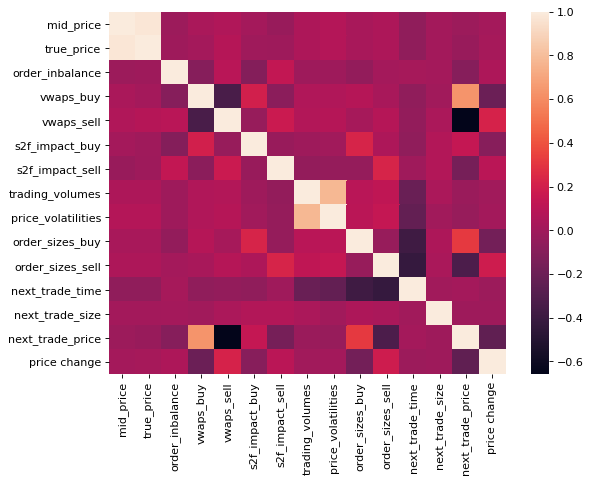

In [154]:
df = pd.DataFrame({
                'mid_price': mid_price.flatten(), 
                'true_price': true_price.flatten(), 
                'order_inbalance': order_inbalance.flatten(), 
                'vwaps_buy': vwaps_buy.flatten(), 
                'vwaps_sell': vwaps_sell.flatten(), 
                's2f_impact_buy': s2f_impact_buy.flatten(), 
                's2f_impact_sell': s2f_impact_sell.flatten(), 
                'trading_volumes': trading_volumes.flatten(), 
                'price_volatilities': price_volatilities.flatten(),
                'order_sizes_buy': order_sizes_buy.flatten(), 
                'order_sizes_sell': order_sizes_sell.flatten(),
                'next_trade_time': next_trade_time.flatten(),
                'next_trade_size': next_trade_size.flatten(),
                'next_trade_price': next_trade_price.flatten(),
                'price change': price_change.flatten()
                })

figure(figsize=(8, 6), dpi=80)
ax = sns.heatmap(df.corr(method='kendall'))
plt.show()

# models

In [155]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier



In [156]:
functions_to_call = {
    'mid_price'                              : get_mid_price_comp,
    'true_price'                             : get_true_price_comp,
    'order_inbalance'                        : get_order_inbalance_comp,
    'vwaps_buy'                              : get_vwap_and_ordersizes_comp,
    'vwaps_sell'                             : get_vwap_and_ordersizes_comp,
    'vwaps_order_sizes_buy'                  : get_vwap_and_ordersizes_comp,
    'vwaps_order_sizes_sell'                 : get_vwap_and_ordersizes_comp,
    's2f_impact_buy'                         : get_s2f_impact_and_ordersizes_comp,
    's2f_impact_sell'                        : get_s2f_impact_and_ordersizes_comp,
    's2f_order_sizes_buy'                    : get_s2f_impact_and_ordersizes_comp,
    's2f_order_sizes_sell'                   : get_s2f_impact_and_ordersizes_comp,
    'trading_volumes'                        : get_trading_volume_and_price_volatility,
    'price_volatilities'                     : get_trading_volume_and_price_volatility,
    'next_trade_time'                        : get_next_trade_x_comp,
    'next_trade_size'                        : get_next_trade_x_comp,
    'next_trade_price'                       : get_next_trade_x_comp,
    'price_change'                           : get_price_change_given_prices
}

In [157]:
def average_smoothing(records, past):      #records - twodimensional array (days, nr_of_bucket), past - how many buckets we look in the past
  #  rolled_records = np.roll(records, past, axis = 1)
   # rolled_records = rolled_records[:,past:]
    rolled_records=records[:,:-past] # does the same as above 
    result = np.zeros(shape = rolled_records.shape)
    for day in range(rolled_records.shape[0]):
        for buck in range(rolled_records.shape[1]):
            count_elem = 0.0
            sum_elem = 0.0
            # loop for changing nans to zeros, np.sum(arr) returns nan if nan is in the arr
            for elem in records[day][buck:buck+past]:
                if not math.isnan(elem):
                    sum_elem+=elem
                    count_elem+=1
            if count_elem>0:
                result[day][buck] = sum_elem/count_elem
            else:
                result[day][buck] = 0
    return result

In [158]:
def up_still_down(x, epsilon = 10e-7):
    if x>epsilon:
        return 1
    elif x<-epsilon:
        return -1
    else:
        return 0
def test_high(x, epsilon = 0.01):
    if x>epsilon:
        return 1
    else:
        return 0
def test_down(x, epsilon = 0.01):
    if x<epsilon:
        return 1
    else:
        return 0
def up_down_bool(x):
    if x>0:
        return True
    else:
        return False
#np.vectorize(up_still_down)(price_change)

In [159]:
def get_y_to_test_max_bool(true_prices, period_of_getting_max, interval_in_data, threshold=10e-7):
    next_indices = period_of_getting_max//interval_in_data
    num_of_days = true_prices.shape[0]
    num_of_averaged_minutes = true_prices.shape[1]
    res = np.empty(true_prices.shape)
    for i in range(num_of_days):
        for j in range(num_of_averaged_minutes):
            max_val=np.max(true_prices[i][j:j+next_indices])
            if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
                res[i][j] = True
            else:
                res[i,j]=False
    return res
def get_y_to_test_min_bool(true_prices, period_of_getting_min, interval_in_data, threshold=10e-7):
    next_indices = period_of_getting_min//interval_in_data
    num_of_days = true_prices.shape[0]
    num_of_averaged_minutes = true_prices.shape[1]
    res = np.empty(true_prices.shape)
    for i in range(num_of_days):
        for j in range(num_of_averaged_minutes):
            min_val=np.min(true_prices[i][j:j+next_indices])
            if (min_val-true_prices[i,j])/true_prices[i,j]<=-threshold: # price swing >= than threshold % of price
                res[i][j] = True
            else:
                res[i,j]=False

    return res

In [160]:
def get_X(comp_id=1, 
                    interval=5, 
                    time_to_skip=0, 
                    time_back=1, 
                    names=[], 
                   ): # use up_and_down or not 
    ## NEED TO ADD y_name PARAMETER AND USE IT!!!
    X = np.empty(shape=(-10*time_back+10*((510-time_to_skip)//interval), len(names)))
    #average_smoothing reduces shape "time_back" times per day
    index=0
    s2f_called=False
    vwap_called=False
    volvol_called=False #volume and price volatility
    s2f_imp=np.empty(shape=(10, (510-time_to_skip)//interval))
    s2f_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    volume=np.empty(shape=(10, (510-time_to_skip)//interval))
    volatility=np.empty(shape=(10, (510-time_to_skip)//interval))
    for name in names:
        if name in ['mid_price', 'true_price', 'order_inbalance']:
            arr = functions_to_call[name](comp_id, interval, time_to_skip)
        elif re.search("vwap", name):
            if not vwap_called:
                vwap, vwap_ord=functions_to_call[name](comp_id, interval, time_to_skip)
                vwap_called=True
            if name in ['vwaps_buy']:
                arr = vwap[:,::2]
            elif name in ['vwaps_sell']:
                arr = vwap[:,1::2]
            elif name in ['vwaps_order_sizes_buy']:
                arr = vwap_ord[:,::2]
            elif name in ['vwaps_order_sizes_sell']:
                arr = vwap_ord[:,1::2]
        elif re.search("s2f", name):
            if not s2f_called:
                s2f_imp, s2f_ord=functions_to_call[name](comp_id, interval, time_to_skip)
                s2f_called=True
            if name in ['s2f_impact_buy']:
                arr = s2f_imp[:,::2]
            elif name in ['s2f_impact_sell']:
                arr = s2f_imp[:,1::2]
            elif name in ['s2f_order_sizes_buy']:
                arr = s2f_ord[:,::2]
            elif name in ['s2f_order_sizes_sell']:
                arr = s2f_ord[:,1::2]  
        elif name in ['trading_volumes', 'price_volatilities']:
            if not volvol_called:
                volume, volatility=functions_to_call[name](comp_id, interval, time_to_skip)
                volvol_called=True
            if name == 'trading_volumes':
                arr = volume
            elif name == 'price_volatilities':
                arr = volatility
        elif name == 'next_trade_time':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='time')
        elif name == 'next_trade_size':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='size')
        elif name == 'next_trade_price':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='price')
        X[:,index]=average_smoothing(arr, time_back).flatten()
        index+=1
    return X

def get_y(comp_id=1, 
        interval=5, 
        time_to_skip=0, 
        time_back=1, 
        y_name='true_price', 
        check='change',
        swing_interval=30,
         threshold=1e-2):
    y = functions_to_call[y_name](comp_id, interval, time_to_skip)
   #??? y = average_smoothing(functions_to_call[y_name](comp_id, interval, time_to_skip), time_back)???
    if check=='change':
        y=functions_to_call['price_change'](y)    
    elif check=='swing_max':
        y=get_y_to_test_max_bool(y, swing_interval, interval, threshold)
    elif check=='swing_min':
        y=get_y_to_test_min_bool(y, swing_interval, interval, threshold)
    else:
        raise ValueError('bad check argument')
    y = y[:,time_back:].flatten()
    return y

In [161]:
def get_X_y_raw(comp_id=1, 
                    interval=5, 
                    time_to_skip=30, 
                    names=[], 
                    y_name='true_price',
                   check_change=False): # use up_and_down or not 
    X = np.empty(shape=(len(names), 10, (510-time_to_skip)//interval))  # parameter, days, timestamps
    index=0
    s2f_called=False
    vwap_called=False
    volvol_called=False #volume and price volatility
    s2f_imp=np.empty(shape=(10, (510-time_to_skip)//interval))
    s2f_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    volume=np.empty(shape=(10, (510-time_to_skip)//interval))
    volatility=np.empty(shape=(10, (510-time_to_skip)//interval))
    for name in names:
        if name in ['mid_price', 'true_price', 'order_inbalance']:
            arr = functions_to_call[name](comp_id, interval, time_to_skip)
        elif name in ['trading_volumes', 'price_volatilities']:
            if not volvol_called:
                volume, volatility=functions_to_call[name](comp_id, interval, time_to_skip)
                volvol_called=True
            if name == 'trading_volumes':
                arr = volume
            elif name == 'price_volatilities':
                arr = volatility
        elif name == 'next_trade_time':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='time')
        elif name == 'next_trade_size':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='size')
        elif name == 'next_trade_price':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='price')   
        elif re.search("vwap", name):
            if not vwap_called:
                vwap, vwap_ord=functions_to_call[name](comp_id, interval, time_to_skip)
                vwap_called=True
            if name in ['vwaps_buy']:
                arr = vwap[:,::2]
            elif name in ['vwaps_sell']:
                arr = vwap[:,1::2]
            elif name in ['vwaps_order_sizes_buy']:
                arr = vwap_ord[:,::2]
            elif name in ['vwaps_order_sizes_sell']:
                arr = vwap_ord[:,1::2]
        elif re.search("s2f", name):
            if not s2f_called:
                s2f_imp, s2f_ord=functions_to_call[name](comp_id, interval, time_to_skip)
                s2f_called=True
            if name in ['s2f_impact_buy']:
                arr = s2f_imp[:,::2]
            elif name in ['s2f_impact_sell']:
                arr = s2f_imp[:,1::2]
            elif name in ['s2f_order_sizes_buy']:
                arr = s2f_ord[:,::2]
            elif name in ['s2f_order_sizes_sell']:
                arr = s2f_ord[:,1::2]            
        else:
            raise ValueError('parameter not found')
        X[index]=arr
        index+=1
    y = functions_to_call[y_name](comp_id, interval, time_to_skip)
    if check_change:
        y=functions_to_call['price_change'](y)    
    
    return X, y

In [162]:
'''
TODO
        #USE REGEX TO CHECK IF STATEMENT
        elif name in ['vwaps_buy', 's2f_impact_buy',   
                      'vwaps_sell', 's2f_impact_sell', 
                      'vwaps_order_sizes_buy', 's2f_order_sizes_buy',
                      'vwaps_order_sizes_sell', 's2f_order_sizes_sell']:
'''

"\nTODO\n        #USE REGEX TO CHECK IF STATEMENT\n        elif name in ['vwaps_buy', 's2f_impact_buy',   \n                      'vwaps_sell', 's2f_impact_sell', \n                      'vwaps_order_sizes_buy', 's2f_order_sizes_buy',\n                      'vwaps_order_sizes_sell', 's2f_order_sizes_sell']:\n"

In [163]:
def get_X_y_averaged(X_raw, y_raw, time_back):
    X_shape=X_raw.shape # parameters, days, timestamps
    X = np.empty(shape=(-X_shape[1]*time_back+X_shape[1]*X_shape[2], X_shape[0]))## we want features as columns, samples as rows
    y=y_raw[:,time_back:].flatten()
    for i in range(X_shape[0]):
        X[:,i]=average_smoothing(X_raw[i], time_back).flatten()
    return X, y

In [164]:
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
param_dict_logreg={}
for n in names:
    param_dict_logreg[n]=[]

In [165]:
def logistic_regr(X, y, split_percent, epsilon=1e-6, comp_id=1, 
                               use_scaling=True, 
                               check_up_down=True, 
                               local_names=names,
                               track_params=False):
    if check_up_down:
        y=np.vectorize(up_still_down)(y,epsilon*average_comp_price[comp_id])#currently we hold price change in y
    split=int(y.size*split_percent)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), LogisticRegression(max_iter=1000)).fit(X[:split], y[:split])
      #  print(clf.named_steps)
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.named_steps['logisticregression'].coef_[0,i])
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.named_steps['logisticregression'].coef_[0,i])
    else:
        clf = LogisticRegression(max_iter=1000).fit(X[:split], y[:split])
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.coef_[0,i])  
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.coef_[0,i])
    y_predicted=clf.predict(X[split:])
    #print("mse: ", mse(y[split:], y_predicted))
    #print("logistic regr score: ", clf.score(X[split:], y[split:]))
    return clf.score(X[split:], y[split:])

In [166]:
def logistic_regr_cross_val(X_train, y_train, X_test, y_test, 
                               use_scaling=True, 
                               local_names=names,
                               track_params=False):
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), LogisticRegression(max_iter=1000)).fit(X_train, y_train)
      #  print(clf.named_steps)
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.named_steps['logisticregression'].coef_[0,i])
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.named_steps['logisticregression'].coef_[0,i])
    else:
        clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.coef_[0,i])  
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.coef_[0,i])
    y_predicted=clf.predict(X_test)
    print("Number of positive class in training dataset =", np.sum(y_train==1))
    print("Number of negative class in training dataset =", np.sum(y_train==0))
    print("Number of positive class in testing dataset =", np.sum(y_test==1))
    print("Number of negative class in testing dataset =", np.sum(y_test==0))
    print("Percent of correct classification:")
    print(np.sum(y_predicted == y_test)/len(y_predicted))
    print("Confusion matrix:")
    conf_mat = confusion_matrix(y_test, y_predicted, labels = [1, 0])
    print(conf_mat)
    if np.unique(y_test).size>1:
        print("Precision:")
        precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
        print(precision)
        print("Recall:")
        recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
        print(recall)
        return clf.score(X_test, y_test), precision, recall
    else:
        return clf.score(X_test, y_test), math.nan, math.nan

In [167]:
def decision_tree(X, y, split_percent, epsilon, comp_id,
                               use_scaling=False, 
                               check_up_down=True, 
                               local_names=names,
                               track_params=False):
    if check_up_down:
        y=np.vectorize(up_still_down)(y,epsilon*average_comp_price[comp_id])#currently we hold price change in y
    split=int(y.size*split_percent)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), DecisionTreeClassifier()).fit(X[:split], y[:split])
       # print(clf.named_steps)
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.named_steps['decisiontreeclassifier'].feature_importances_[i])
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.named_steps['decisiontreeclassifier'].feature_importances_[i])
    else:
        clf = DecisionTreeClassifier().fit(X[:split], y[:split])
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.feature_importances_[i])  
        else:
            print("Coefficient impact:")
          #  print(clf.feature_importances_)
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.feature_importances_[i])
    y_predicted=clf.predict(X[split:])
    #print("mse: ", mse(y[split:], y_predicted))
    #print("decision tree score: ", clf.score(X[split:], y[split:]))
    return clf.score(X[split:], y[split:])

In [168]:
average_comp_price=np.zeros(len(list_of_companies_number))
for i in range(average_comp_price.size):
    average_comp_price[i]=np.average(get_true_price_comp(comp_id=i, interval=1, time_to_skip=30))

In [169]:
comp_id = 3
interval=5
time_to_skip=30
time_back=1
split_percent = 0.8
epsilon=0.000001

In [170]:
print(average_comp_price[comp_id])
X=get_X(comp_id, interval, time_to_skip, time_back, names)
y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', check='change')
print("decision_tree")
print("score: ",decision_tree(X, np.copy(y),split_percent, epsilon, comp_id, use_scaling=True, local_names=names))
print("log reg")
print("score: ",logistic_regr(X, np.copy(y),split_percent, epsilon, comp_id, use_scaling=True, local_names=names))




851.5752484506002
30.520833333333332% of intervals were SELL empty
17.34375% of intervals were BUY empty
1.09375% of intervals were set not filled
decision_tree
Coefficient impact:
order_inbalance   0.15270236350313743
vwaps_buy   0.06763848601049427
vwaps_sell   0.07917015028217277
s2f_impact_buy   0.04458697053684982
s2f_impact_sell   0.07060789107629584
trading_volumes   0.09342033919630727
price_volatilities   0.011016544814415987
vwaps_order_sizes_buy   0.04067989209404015
vwaps_order_sizes_sell   0.04103575342367197
s2f_order_sizes_buy   0.026137214970094753
s2f_order_sizes_sell   0.028860715023339853
next_trade_time   0.11428787894836209
next_trade_size   0.1405144229753436
next_trade_price   0.08934137714547423
score:  0.5052631578947369
log reg
Coefficient impact:
order_inbalance   -0.1910045991253946
vwaps_buy   0.43076290820048996
vwaps_sell   0.1083338812489518
s2f_impact_buy   -0.008380857620515568
s2f_impact_sell   0.49326056669135276
trading_volumes   0.3087686681689265


In [171]:
def xgb_cross_val(X_train, y_train, X_test, y_test, use_scaling=True):
    neg_class_count = np.sum(y_train==0)
    pos_class_count = np.sum(y_train==1)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), xgb.XGBClassifier(max_depth=5, scale_pos_weight=neg_class_count/pos_class_count)).fit(X_train, y_train)
    else:
        clf = xgb.XGBClassifier().fit(X_train, y_train)
    y_predicted=clf.predict(X_test)
    print("Number of positive class in training dataset =", np.sum(y_train==1))
    print("Number of negative class in training dataset =", np.sum(y_train==0))
    print("Number of positive class in testing dataset =", np.sum(y_test==1))
    print("Number of negative class in testing dataset =", np.sum(y_test==0))
    print("Percent of correct classification:")
    print(np.sum(y_predicted == y_test)/len(y_predicted))
    print("Confusion matrix:")
    conf_mat = confusion_matrix(y_test, y_predicted, labels = [1, 0])
    print(conf_mat)
    if np.unique(y_test).size>1:
        print("Precision:")
        precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
        print(precision)
        print("Recall:")
        recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
        print(recall)
    #print("mse: ", mse(y[split:], y_predicted))
    #print("logistic regr score: ", clf.score(X[split:], y[split:]))
        return clf.score(X_test, y_test), precision, recall
    else:
        return clf.score(X_test, y_test), math.nan, math.nan

In [172]:
def dec_tree_cross_val(X_train, y_train, X_test, y_test, use_scaling=True):
    neg_class_count = np.sum(y_train==0)
    pos_class_count = np.sum(y_train==1)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), DecisionTreeClassifier()).fit(X_train, y_train)
    else:
        clf = DecisionTreeClassifier().fit(X_train, y_train)
    y_predicted=clf.predict(X_test)
    print("Number of positive class in training dataset =", np.sum(y_train==1))
    print("Number of negative class in training dataset =", np.sum(y_train==0))
    print("Number of positive class in testing dataset =", np.sum(y_test==1))
    print("Number of negative class in testing dataset =", np.sum(y_test==0))
    print("Percent of correct classification:")
    print(np.sum(y_predicted == y_test)/len(y_predicted))
    print("Confusion matrix:")
    conf_mat = confusion_matrix(y_test, y_predicted, labels = [1, 0])
    print(conf_mat)
    if np.unique(y_test).size>1:
        print("Precision:")
        precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
        print(precision)
        print("Recall:")
        recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
        print(recall)
    #print("mse: ", mse(y[split:], y_predicted))
    #print("logistic regr score: ", clf.score(X[split:], y[split:]))
        return clf.score(X_test, y_test), precision, recall
    else:
        return clf.score(X_test, y_test), math.nan, math.nan

In [173]:
def cross_validation(X, y, model, num_of_day = 10, use_scaling = True):
    num_of_samples_in_day = X.shape[0]//num_of_day
    plot_indicators = np.zeros(shape = (10, 3))
    for day in range(num_of_day):
        try:
            X_train = np.concatenate((X[:day*num_of_samples_in_day], X[(day+1)*num_of_samples_in_day:]))
            y_train = np.concatenate((y[:day*num_of_samples_in_day], y[(day+1)*num_of_samples_in_day:]))
            X_test = X[day*num_of_samples_in_day:(day+1)*num_of_samples_in_day]
            y_test = y[day*num_of_samples_in_day:(day+1)*num_of_samples_in_day]
            if model == 'log_reg':
                score, precision, recall = logistic_regr_cross_val(X_train, y_train, X_test, y_test, use_scaling = use_scaling, local_names=names,track_params=False)
                plot_indicators[day][0] = score
                plot_indicators[day][1] = precision
                plot_indicators[day][2] = recall
            elif model == 'xgb':
                score, precision, recall = xgb_cross_val(X_train, y_train, X_test, y_test, use_scaling = use_scaling)
                plot_indicators[day][0] = score
                plot_indicators[day][1] = precision
                plot_indicators[day][2] = recall
            elif model == 'dec_tree':
                score, precision, recall = dec_tree_cross_val(X_train, y_train, X_test, y_test, use_scaling = use_scaling)
                plot_indicators[day][0] = score
                plot_indicators[day][1] = precision
                plot_indicators[day][2] = recall
        except ValueError as err:
            plot_indicators[day][0] = math.nan
            plot_indicators[day][1] = math.nan
            plot_indicators[day][2] = math.nan
            print(err)
    return plot_indicators

# Testy modeli na wybranym thresholdzie i porównanie

In [174]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
import xgboost as xgb
from sklearn.metrics import confusion_matrix

### Bez skalowania

Mean of all companies for max

In [175]:
interval=3
time_to_skip=30
time_back=5
y_name='true_price'
swing_interval = 60
check = 'swing_max'
use_scaling = False
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.001
sum_of_acc_log_reg = 0.0
sum_of_prec_log_reg = 0.0
sum_of_recall_log_reg = 0.0
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
sum_of_acc_tree = 0.0
sum_of_prec_tree = 0.0
sum_of_recall_tree = 0.0

#### Logistic regression

In [176]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'log_reg',use_scaling = use_scaling)
    sum_of_acc_log_reg+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_log_reg += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_log_reg += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

#### Xgb

In [53]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'xgb',use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

#### Decision trees

In [54]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'dec_tree',use_scaling = use_scaling)
    sum_of_acc_tree+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_tree += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_tree += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

In [55]:
print("Average accuracy without scaling:\n")
print("Logistic regression:",sum_of_acc_log_reg/99)
print("XGB:",sum_of_acc_xgb/99)
print("Decision trees:",sum_of_acc_tree/99)

Average accuracy without scaling:

Logistic regression: 0.591300097751711
XGB: 0.5532355816226786
Decision trees: 0.5311697621375042


In [56]:
print("Average precision without scaling:\n")
print("Logistic regression:",sum_of_prec_log_reg/99)
print("XGB:",sum_of_prec_xgb/99)
print("Decision trees:",sum_of_prec_tree/99)

Average precision without scaling:

Logistic regression: 0.8418572830182667
XGB: 0.6730751326290682
Decision trees: 0.6014339174241536


In [57]:
print("Average recall without scaling:\n")
print("Logistic regression:",sum_of_recall_log_reg/99)
print("XGB:",sum_of_recall_xgb/99)
print("Decision trees:",sum_of_recall_tree/99)

Average recall without scaling:

Logistic regression: 0.6154002079250696
XGB: 0.6110776652910481
Decision trees: 0.6071723051666771


Mean of all companies for min

In [58]:
interval=3
time_to_skip=30
time_back=5
y_name='true_price'
swing_interval = 60
check = 'swing_min'
use_scaling = False
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.001
sum_of_acc_log_reg = 0.0
sum_of_prec_log_reg = 0.0
sum_of_recall_log_reg = 0.0
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
sum_of_acc_tree = 0.0
sum_of_prec_tree = 0.0
sum_of_recall_tree = 0.0

#### Logistic regression

In [59]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'log_reg',use_scaling = use_scaling)
    sum_of_acc_log_reg+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_log_reg += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_log_reg += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

#### XGB

In [60]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'xgb',use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

#### Decision trees

In [61]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'dec_tree',use_scaling = use_scaling)
    sum_of_acc_tree+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_tree += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_tree += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

In [62]:
print("Average accuracy without scaling:\n")
print("Logistic regression:",sum_of_acc_log_reg/99)
print("XGB:",sum_of_acc_xgb/99)
print("Decision trees:",sum_of_acc_tree/99)

Average accuracy without scaling:

Logistic regression: 0.5719061583577715
XGB: 0.5409775171065493
Decision trees: 0.5230498533724339


In [63]:
print("Average precision without scaling:\n")
print("Logistic regression:",sum_of_prec_log_reg/99)
print("XGB:",sum_of_prec_xgb/99)
print("Decision trees:",sum_of_prec_tree/99)

Average precision without scaling:

Logistic regression: 0.8057993652151226
XGB: 0.6436223268750241
Decision trees: 0.5814739715687307


In [64]:
print("Average recall without scaling:\n")
print("Logistic regression:",sum_of_recall_log_reg/99)
print("XGB:",sum_of_recall_xgb/99)
print("Decision trees:",sum_of_recall_tree/99)

Average recall without scaling:

Logistic regression: nan
XGB: 0.5933873797836193
Decision trees: 0.5883842645031725


#### Ze skalowaniem

Mean on all companies for max

In [65]:
interval=3
time_to_skip=30
time_back=5
y_name='true_price'
swing_interval = 60
check = 'swing_max'
use_scaling = True
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.001
sum_of_acc_log_reg = 0.0
sum_of_prec_log_reg = 0.0
sum_of_recall_log_reg = 0.0
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
sum_of_acc_tree = 0.0
sum_of_prec_tree = 0.0
sum_of_recall_tree = 0.0

#### Logistic regression

In [66]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'log_reg',use_scaling = use_scaling)
    sum_of_acc_log_reg+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_log_reg += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_log_reg += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

#### Xgb

In [67]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'xgb',use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

#### Decision trees

In [68]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'dec_tree',use_scaling = use_scaling)
    sum_of_acc_tree+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_tree += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_tree += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

In [69]:
print("Average accuracy without scaling:\n")
print("Logistic regression:",sum_of_acc_log_reg/99)
print("XGB:",sum_of_acc_xgb/99)
print("Decision trees:",sum_of_acc_tree/99)

Average accuracy without scaling:

Logistic regression: 0.5813294232649073
XGB: 0.5466275659824046
Decision trees: 0.5285956337569239


In [70]:
print("Average precision without scaling:\n")
print("Logistic regression:",sum_of_prec_log_reg/99)
print("XGB:",sum_of_prec_xgb/99)
print("Decision trees:",sum_of_prec_tree/99)

Average precision without scaling:

Logistic regression: 0.8139897595520601
XGB: 0.6376635450294516
Decision trees: 0.601475699397406


In [71]:
print("Average recall without scaling:\n")
print("Logistic regression:",sum_of_recall_log_reg/99)
print("XGB:",sum_of_recall_xgb/99)
print("Decision trees:",sum_of_recall_tree/99)

Average recall without scaling:

Logistic regression: 0.6128369904339649
XGB: 0.6139030288409352
Decision trees: 0.604480733806657


Mean of all companies for min

In [72]:
interval=3
time_to_skip=30
time_back=5
y_name='true_price'
swing_interval = 60
check = 'swing_min'
use_scaling = True
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.001
sum_of_acc_log_reg = 0.0
sum_of_prec_log_reg = 0.0
sum_of_recall_log_reg = 0.0
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
sum_of_acc_tree = 0.0
sum_of_prec_tree = 0.0
sum_of_recall_tree = 0.0

#### Logistic regression

In [73]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'log_reg',use_scaling = use_scaling)
    sum_of_acc_log_reg+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_log_reg += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_log_reg += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

#### Xgb

In [74]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'xgb',use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

#### Decision trees

In [75]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'dec_tree',use_scaling = use_scaling)
    sum_of_acc_tree+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_tree += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_tree += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

In [76]:
print("Average accuracy without scaling:\n")
print("Logistic regression:",sum_of_acc_log_reg/99)
print("XGB:",sum_of_acc_xgb/99)
print("Decision trees:",sum_of_acc_tree/99)

Average accuracy without scaling:

Logistic regression: 0.5692016943629847
XGB: 0.5349364613880743
Decision trees: 0.52078853046595


In [77]:
print("Average precision without scaling:\n")
print("Logistic regression:",sum_of_prec_log_reg/99)
print("XGB:",sum_of_prec_xgb/99)
print("Decision trees:",sum_of_prec_tree/99)

Average precision without scaling:

Logistic regression: 0.7925245719143386
XGB: 0.6126065012172246
Decision trees: 0.580177100987619


In [78]:
print("Average recall without scaling:\n")
print("Logistic regression:",sum_of_recall_log_reg/99)
print("XGB:",sum_of_recall_xgb/99)
print("Decision trees:",sum_of_recall_tree/99)

Average recall without scaling:

Logistic regression: 0.5954272549493953
XGB: 0.5953578633846031
Decision trees: 0.5855986882778026


#### Max z kolejnej godziny patrząc na ostatnie 5 min grupując dane co 5 min

In [79]:
interval=2
time_to_skip=30
time_back=3
y_name='true_price'
swing_interval = 60
check = 'swing_max'
use_scaling = True
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.001
sum_of_acc_log_reg = 0.0
sum_of_prec_log_reg = 0.0
sum_of_recall_log_reg = 0.0
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
sum_of_acc_tree = 0.0
sum_of_prec_tree = 0.0
sum_of_recall_tree = 0.0

#### Logistic regression

In [80]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'log_reg',use_scaling = use_scaling)
    sum_of_acc_log_reg+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_log_reg += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_log_reg += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

#### Xgb

In [81]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'xgb',use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

#### Decision trees

In [82]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'dec_tree',use_scaling = use_scaling)
    sum_of_acc_tree+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_tree += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_tree += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

In [83]:
print("Average accuracy without scaling:\n")
print("Logistic regression:",sum_of_acc_log_reg/99)
print("XGB:",sum_of_acc_xgb/99)
print("Decision trees:",sum_of_acc_tree/99)

Average accuracy without scaling:

Logistic regression: 0.6058560286408389
XGB: 0.5513190981545413
Decision trees: 0.5382431914077481


In [84]:
print("Average precision without scaling:\n")
print("Logistic regression:",sum_of_prec_log_reg/99)
print("XGB:",sum_of_prec_xgb/99)
print("Decision trees:",sum_of_prec_tree/99)

Average precision without scaling:

Logistic regression: 0.8782754968512432
XGB: 0.6457570057771509
Decision trees: 0.619380304077697


In [85]:
print("Average recall without scaling:\n")
print("Logistic regression:",sum_of_recall_log_reg/99)
print("XGB:",sum_of_recall_xgb/99)
print("Decision trees:",sum_of_recall_tree/99)

Average recall without scaling:

Logistic regression: 0.6287281907675495
XGB: 0.6329515110006729
Decision trees: 0.626195445798759


#### Max z kolejnej godziny patrząc na ostatnie 10 min grupując dane co 5 min

In [86]:
interval=3
time_to_skip=30
time_back=4
y_name='true_price'
swing_interval = 60
check = 'swing_max'
use_scaling = True
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.001
sum_of_acc_log_reg = 0.0
sum_of_prec_log_reg = 0.0
sum_of_recall_log_reg = 0.0
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
sum_of_acc_tree = 0.0
sum_of_prec_tree = 0.0
sum_of_recall_tree = 0.0

#### Logistic regression

In [87]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'log_reg',use_scaling = use_scaling)
    sum_of_acc_log_reg+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_log_reg += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_log_reg += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

#### Xgb

In [88]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'xgb',use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

#### Decision trees

In [89]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'dec_tree',use_scaling = use_scaling)
    sum_of_acc_tree+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_tree += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_tree += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

In [90]:
print("Average accuracy without scaling:\n")
print("Logistic regression:",sum_of_acc_log_reg/99)
print("XGB:",sum_of_acc_xgb/99)
print("Decision trees:",sum_of_acc_tree/99)

Average accuracy without scaling:

Logistic regression: 0.5817469567469569
XGB: 0.5421004921004922
Decision trees: 0.528885003885004


In [91]:
print("Average precision without scaling:\n")
print("Logistic regression:",sum_of_prec_log_reg/99)
print("XGB:",sum_of_prec_xgb/99)
print("Decision trees:",sum_of_prec_tree/99)

Average precision without scaling:

Logistic regression: 0.8188947927420115
XGB: 0.6314887633062229
Decision trees: 0.5995085756748398


In [92]:
print("Average recall without scaling:\n")
print("Logistic regression:",sum_of_recall_log_reg/99)
print("XGB:",sum_of_recall_xgb/99)
print("Decision trees:",sum_of_recall_tree/99)

Average recall without scaling:

Logistic regression: 0.6120697385996869
XGB: 0.6104404698838766
Decision trees: 0.6050436996170078


#### Min z kolejnej godziny patrząc na ostatnie 5 min grupując dane co 5 min

In [85]:
interval=3
time_to_skip=30
time_back=2
y_name='true_price'
swing_interval = 60
check = 'swing_min'
use_scaling = True
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.001
sum_of_acc_log_reg = 0.0
sum_of_prec_log_reg = 0.0
sum_of_recall_log_reg = 0.0
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
sum_of_acc_tree = 0.0
sum_of_prec_tree = 0.0
sum_of_recall_tree = 0.0

#### Logistic regression

In [86]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'log_reg',use_scaling = use_scaling)
    sum_of_acc_log_reg+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_log_reg += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_log_reg += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

#### Xgb

In [87]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'xgb',use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

#### Decision trees

In [88]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'dec_tree',use_scaling = use_scaling)
    sum_of_acc_tree+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_tree += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_tree += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

In [89]:
print("Average accuracy without scaling:\n")
print("Logistic regression:",sum_of_acc_log_reg/99)
print("XGB:",sum_of_acc_xgb/99)
print("Decision trees:",sum_of_acc_tree/99)

Average accuracy without scaling:

Logistic regression: 0.5399267399267399
XGB: 0.5231879231879234
Decision trees: 0.5124875124875126


In [90]:
print("Average precision without scaling:\n")
print("Logistic regression:",sum_of_prec_log_reg/99)
print("XGB:",sum_of_prec_xgb/99)
print("Decision trees:",sum_of_prec_tree/99)

Average precision without scaling:

Logistic regression: 0.6712206892217817
XGB: 0.5761647396637581
Decision trees: 0.5489035760149672


In [91]:
print("Average recall without scaling:\n")
print("Logistic regression:",sum_of_recall_log_reg/99)
print("XGB:",sum_of_recall_xgb/99)
print("Decision trees:",sum_of_recall_tree/99)

Average recall without scaling:

Logistic regression: nan
XGB: 0.5598581318550807
Decision trees: 0.5517153141834775


#### Min z kolejnej godziny patrząc na ostatnie 10 min grupując dane co 5 min

In [92]:
interval=3
time_to_skip=30
time_back=4
y_name='true_price'
swing_interval = 60
check = 'swing_min'
use_scaling = True
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.001
sum_of_acc_log_reg = 0.0
sum_of_prec_log_reg = 0.0
sum_of_recall_log_reg = 0.0
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
sum_of_acc_tree = 0.0
sum_of_prec_tree = 0.0
sum_of_recall_tree = 0.0

#### Logistic regression

In [93]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'log_reg',use_scaling = use_scaling)
    sum_of_acc_log_reg+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_log_reg += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_log_reg += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

#### Xgb

In [94]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'xgb',use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

#### Decision trees

In [95]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'dec_tree',use_scaling = use_scaling)
    sum_of_acc_tree+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_tree += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_tree += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

In [96]:
print("Average accuracy without scaling:\n")
print("Logistic regression:",sum_of_acc_log_reg/99)
print("XGB:",sum_of_acc_xgb/99)
print("Decision trees:",sum_of_acc_tree/99)

Average accuracy without scaling:

Logistic regression: 0.5285647169368097
XGB: 0.5142706131078223
Decision trees: 0.5104886070002352


In [97]:
print("Average precision without scaling:\n")
print("Logistic regression:",sum_of_prec_log_reg/99)
print("XGB:",sum_of_prec_xgb/99)
print("Decision trees:",sum_of_prec_tree/99)

Average precision without scaling:

Logistic regression: 0.6261866393564482
XGB: 0.5498742053257208
Decision trees: 0.5305575952194354


In [98]:
print("Average recall without scaling:\n")
print("Logistic regression:",sum_of_recall_log_reg/99)
print("XGB:",sum_of_recall_xgb/99)
print("Decision trees:",sum_of_recall_tree/99)

Average recall without scaling:

Logistic regression: nan
XGB: 0.5445310605497603
Decision trees: 0.5383872064161256


#### Max z kolejnych 3 godzin patrząc na ostatnie 30 min i biorąc threshold 0.003

In [99]:
interval=3
time_to_skip=30
time_back=10
y_name='true_price'
swing_interval = 180
check = 'swing_max'
use_scaling = True
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.003
sum_of_acc_log_reg = 0.0
sum_of_prec_log_reg = 0.0
sum_of_recall_log_reg = 0.0
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
sum_of_acc_tree = 0.0
sum_of_prec_tree = 0.0
sum_of_recall_tree = 0.0

#### Logistic regression

In [100]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'log_reg',use_scaling = use_scaling)
    sum_of_acc_log_reg+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_log_reg += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_log_reg += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

#### Xgb

In [101]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'xgb',use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

#### Decision trees

In [102]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'dec_tree',use_scaling = use_scaling)
    sum_of_acc_tree+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_tree += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_tree += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

In [103]:
print("Average accuracy without scaling:\n")
print("Logistic regression:",sum_of_acc_log_reg/99)
print("XGB:",sum_of_acc_xgb/99)
print("Decision trees:",sum_of_acc_tree/99)

Average accuracy without scaling:

Logistic regression: 0.5476767676767677
XGB: 0.5416783216783218
Decision trees: 0.5295493395493394


In [104]:
print("Average precision without scaling:\n")
print("Logistic regression:",sum_of_prec_log_reg/99)
print("XGB:",sum_of_prec_xgb/99)
print("Decision trees:",sum_of_prec_tree/99)

Average precision without scaling:

Logistic regression: nan
XGB: nan
Decision trees: nan


In [105]:
print("Average recall without scaling:\n")
print("Logistic regression:",sum_of_recall_log_reg/99)
print("XGB:",sum_of_recall_xgb/99)
print("Decision trees:",sum_of_recall_tree/99)

Average recall without scaling:

Logistic regression: nan
XGB: nan
Decision trees: nan


#### Max z kolejnych 3 godzin patrząc na ostatnie 60 min i biorąc threshold 0.003

In [106]:
interval=3
time_to_skip=30
time_back=20
y_name='true_price'
swing_interval = 180
check = 'swing_max'
use_scaling = True
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.003
sum_of_acc_log_reg = 0.0
sum_of_prec_log_reg = 0.0
sum_of_recall_log_reg = 0.0
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
sum_of_acc_tree = 0.0
sum_of_prec_tree = 0.0
sum_of_recall_tree = 0.0

#### Logistic regression

In [107]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'log_reg',use_scaling = use_scaling)
    sum_of_acc_log_reg+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_log_reg += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_log_reg += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

#### Xgb

In [108]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'xgb',use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

#### Decision trees

In [109]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'dec_tree',use_scaling = use_scaling)
    sum_of_acc_tree+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_tree += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_tree += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

In [110]:
print("Average accuracy without scaling:\n")
print("Logistic regression:",sum_of_acc_log_reg/99)
print("XGB:",sum_of_acc_xgb/99)
print("Decision trees:",sum_of_acc_tree/99)

Average accuracy without scaling:

Logistic regression: 0.5454848484848488
XGB: 0.5497979797979798
Decision trees: 0.5307979797979797


In [111]:
print("Average precision without scaling:\n")
print("Logistic regression:",sum_of_prec_log_reg/99)
print("XGB:",sum_of_prec_xgb/99)
print("Decision trees:",sum_of_prec_tree/99)

Average precision without scaling:

Logistic regression: nan
XGB: nan
Decision trees: nan


In [112]:
print("Average recall without scaling:\n")
print("Logistic regression:",sum_of_recall_log_reg/99)
print("XGB:",sum_of_recall_xgb/99)
print("Decision trees:",sum_of_recall_tree/99)

Average recall without scaling:

Logistic regression: nan
XGB: nan
Decision trees: nan


#### Min z kolejnych 3 godzin patrząc na ostatnie 30 min i biorąc threshold 0.003

In [113]:
interval=3
time_to_skip=30
time_back=10
y_name='true_price'
swing_interval = 180
check = 'swing_min'
use_scaling = True
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.003
sum_of_acc_log_reg = 0.0
sum_of_prec_log_reg = 0.0
sum_of_recall_log_reg = 0.0
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
sum_of_acc_tree = 0.0
sum_of_prec_tree = 0.0
sum_of_recall_tree = 0.0

#### Logistic regression

In [114]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'log_reg',use_scaling = use_scaling)
    sum_of_acc_log_reg+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_log_reg += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_log_reg += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

#### Xgb

In [115]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'xgb',use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

#### Decision trees

In [116]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'dec_tree',use_scaling = use_scaling)
    sum_of_acc_tree+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_tree += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_tree += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

In [117]:
print("Average accuracy without scaling:\n")
print("Logistic regression:",sum_of_acc_log_reg/99)
print("XGB:",sum_of_acc_xgb/99)
print("Decision trees:",sum_of_acc_tree/99)

Average accuracy without scaling:

Logistic regression: 0.589222999222999
XGB: 0.5771561771561772
Decision trees: 0.5518181818181818


In [118]:
print("Average precision without scaling:\n")
print("Logistic regression:",sum_of_prec_log_reg/99)
print("XGB:",sum_of_prec_xgb/99)
print("Decision trees:",sum_of_prec_tree/99)

Average precision without scaling:

Logistic regression: nan
XGB: nan
Decision trees: nan


In [119]:
print("Average recall without scaling:\n")
print("Logistic regression:",sum_of_recall_log_reg/99)
print("XGB:",sum_of_recall_xgb/99)
print("Decision trees:",sum_of_recall_tree/99)

Average recall without scaling:

Logistic regression: nan
XGB: nan
Decision trees: nan


#### Min z kolejnych 3 godzin patrząc na ostatnie 60 min i biorąc threshold 0.003

In [120]:
interval=3
time_to_skip=30
time_back=20
y_name='true_price'
swing_interval = 180
check = 'swing_min'
use_scaling = True
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
threshold = 0.003
sum_of_acc_log_reg = 0.0
sum_of_prec_log_reg = 0.0
sum_of_recall_log_reg = 0.0
sum_of_acc_xgb = 0.0
sum_of_prec_xgb = 0.0
sum_of_recall_xgb = 0.0
sum_of_acc_tree = 0.0
sum_of_prec_tree = 0.0
sum_of_recall_tree = 0.0

#### Logistic regression

In [121]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'log_reg',use_scaling = use_scaling)
    sum_of_acc_log_reg+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_log_reg += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_log_reg += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

#### Xgb

In [122]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'xgb',use_scaling = use_scaling)
    sum_of_acc_xgb+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_xgb += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_xgb += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

#### Decision trees

In [123]:
for comp_id in range(99):
    print("comp_id =",comp_id)
    X = get_X(comp_id, interval, time_to_skip, time_back, names)
    y = get_y(comp_id, interval, time_to_skip, time_back, check = check, swing_interval = swing_interval, threshold=threshold)
    res_per_day = cross_validation(X, y, 'dec_tree',use_scaling = use_scaling)
    sum_of_acc_tree+=np.sum(res_per_day[:,0])/res_per_day.shape[0]
    sum_of_prec_tree += np.sum(res_per_day[:,1])/res_per_day.shape[0]
    sum_of_recall_tree += np.sum(res_per_day[:,2])/res_per_day.shape[0]
    clear_output(wait=True)
clear_output(wait=True)

In [124]:
print("Average accuracy without scaling:\n")
print("Logistic regression:",sum_of_acc_log_reg/99)
print("XGB:",sum_of_acc_xgb/99)
print("Decision trees:",sum_of_acc_tree/99)

Average accuracy without scaling:

Logistic regression: 0.580121212121212
XGB: 0.571040404040404
Decision trees: 0.5404040404040403


In [125]:
print("Average precision without scaling:\n")
print("Logistic regression:",sum_of_prec_log_reg/99)
print("XGB:",sum_of_prec_xgb/99)
print("Decision trees:",sum_of_prec_tree/99)

Average precision without scaling:

Logistic regression: nan
XGB: nan
Decision trees: nan


In [126]:
print("Average recall without scaling:\n")
print("Logistic regression:",sum_of_recall_log_reg/99)
print("XGB:",sum_of_recall_xgb/99)
print("Decision trees:",sum_of_recall_tree/99)

Average recall without scaling:

Logistic regression: nan
XGB: nan
Decision trees: nan


In [197]:
!pip install torch

In [198]:
#!pip install torch
import torch
x = torch.rand(5, 3)
print(x)

OSError: [WinError 127] Nie można odnaleźć określonej procedury. Error loading "C:\Users\Jacek\anaconda3\lib\site-packages\torch\lib\cufftw64_10.dll" or one of its dependencies.

In [186]:
#!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [187]:
average_comp_price=np.zeros(len(list_of_companies_number))
for i in range(average_comp_price.size):
    average_comp_price[i]=np.average(get_true_price_comp(comp_id=i, interval=1, time_to_skip=30))

In [188]:
def prep_data_to_NN(comp_id = 15, interval = 5, time_to_skip = 30, time_back = 1, split_percent = 0.8, threshold = 0.001):
#print(average_comp_price[comp_id])
    X=get_X(comp_id, interval, time_to_skip, time_back, names)
    y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', check='swing_max', threshold = threshold)
    end_split = int(split_percent * X.shape[0])
    X_train = X[:end_split]
    y_train = y[:end_split]
    X_test = X[end_split:]
    y_test = y[end_split:]
    print(np.sum(y==1))
    print(y.shape)
    print("decision_tree")
    print("score: ",decision_tree(X, np.copy(y),split_percent, threshold, comp_id, use_scaling=True, local_names=names))
    print("log reg")
    print("score: ",logistic_regr(X, np.copy(y),split_percent, threshold, comp_id, use_scaling=True, local_names=names))
    return X_train, y_train, X_test, y_test


In [189]:
X_train, y_train, X_test, y_test = prep_data_to_NN(comp_id = 10)
y_train = tf.one_hot(y_train, depth = 2)
y_test = tf.one_hot(y_test, depth = 2)
model = tf.keras.models.Sequential([                    
    #tf.keras.layers.Conv1(filters= 2, kernel_size = 3, activation='tanh', use_bias=False),
    #tf.keras.layers.MaxPool2D(),
    #tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, use_bias=True, activation="relu", input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(1024, use_bias=True, activation="softmax"),
    tf.keras.layers.Dense(1024, use_bias=True, activation="softmax"),
    tf.keras.layers.Dense(512, use_bias=True, activation="softmax"),
    tf.keras.layers.Dense(64, use_bias=True, activation="softmax"),
    tf.keras.layers.Dense(2, use_bias=True, activation="relu")
  ])

model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=[tf.keras.metrics.CategoricalAccuracy()],
  )

model.fit(
      X_train,
      y_train,
      epochs=100,
      verbose = 1
  )

print("NN score: ")
model.evaluate(X_test, y_test, verbose=1)
preds = model.predict(X_test)
move_pred = 0
stay_pred = 0
correct = 0
for i in range(preds.shape[0]):
    if preds[i][0]>preds[i][1]:
        if y_test[i][0]==1:
            correct+=1
        move_pred+=1
    else:
        if y_test[i][1]==0:
            correct+=1
        stay_pred+=1
print("NN score test: ", 
        " move preds: ", move_pred,
        " stay preds: ", stay_pred,
        " accuracy:   ", correct/preds.shape[0]
  )

13.645833333333334% of intervals were SELL empty
31.666666666666668% of intervals were BUY empty
0.7291666666666666% of intervals were set not filled
328
(950,)
decision_tree
Coefficient impact:
order_inbalance   0.15607152088600282
vwaps_buy   0.043894680781018
vwaps_sell   0.07256045155671137
s2f_impact_buy   0.053009447878121105
s2f_impact_sell   0.1117832472797342
trading_volumes   0.08102668945977601
price_volatilities   0.012115455139434133
vwaps_order_sizes_buy   0.009904867205675722
vwaps_order_sizes_sell   0.06937566260213665
s2f_order_sizes_buy   0.022208253780844227
s2f_order_sizes_sell   0.06110903196060731
next_trade_time   0.1421287741382494
next_trade_size   0.08977328455725116
next_trade_price   0.07503863277443794
score:  0.5263157894736842
log reg
Coefficient impact:
order_inbalance   -0.1257692375344754
vwaps_buy   0.34705701026577895
vwaps_sell   0.7695476696850684
s2f_impact_buy   0.700607736731457
s2f_impact_sell   0.8097223969514264
trading_volumes   0.1340318063

24/24 [==============================] - 2s 64ms/step - loss: nan - categorical_accuracy: 0.6566
Epoch 63/100
24/24 [==============================] - 2s 80ms/step - loss: nan - categorical_accuracy: 0.6566
Epoch 64/100
24/24 [==============================] - 1s 54ms/step - loss: nan - categorical_accuracy: 0.6566
Epoch 65/100
24/24 [==============================] - 1s 45ms/step - loss: nan - categorical_accuracy: 0.6566
Epoch 66/100
24/24 [==============================] - 3s 140ms/step - loss: nan - categorical_accuracy: 0.6566
Epoch 67/100
24/24 [==============================] - 3s 136ms/step - loss: nan - categorical_accuracy: 0.6566
Epoch 68/100
24/24 [==============================] - 2s 102ms/step - loss: nan - categorical_accuracy: 0.6566
Epoch 69/100
24/24 [==============================] - 2s 101ms/step - loss: nan - categorical_accuracy: 0.6566
Epoch 70/100
24/24 [==============================] - 2s 97ms/step - loss: nan - categorical_accuracy: 0.6566
Epoch 71/100
24/24 

#### LSTM

In [190]:
X_train, y_train, X_test, y_test = prep_data_to_NN(comp_id = 10)
y_train = tf.one_hot(y_train, depth = 2)
y_test = tf.one_hot(y_test, depth = 2)
model = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(layers.Dense(256, use_bias=True, activation="relu", input_shape=(X.shape[1],)))

# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(128))

# Add a Dense layer with 10 units.
model.add(layers.Dense(64))
model.add(layers.Dense(2))

model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=[tf.keras.metrics.CategoricalAccuracy()],
  )

model.fit(
      X_train,
      y_train,
      epochs=100,
      verbose = 1
  )

print("NN score: ")
model.evaluate(X_test, y_test, verbose=1)
preds = model.predict(X_test)
move_pred = 0
stay_pred = 0
correct = 0
for i in range(preds.shape[0]):
    if preds[i][0]>preds[i][1]:
        if y_test[i][0]==1:
            correct+=1
        move_pred+=1
    else:
        if y_test[i][1]==0:
            correct+=1
        stay_pred+=1
print("NN score test: ", 
        " move preds: ", move_pred,
        " stay preds: ", stay_pred,
        " accuracy:   ", correct/preds.shape[0]
  )

13.645833333333334% of intervals were SELL empty
31.666666666666668% of intervals were BUY empty
0.7291666666666666% of intervals were set not filled
328
(950,)
decision_tree
Coefficient impact:
order_inbalance   0.16091353478060466
vwaps_buy   0.022410441355148185
vwaps_sell   0.0674428758957501
s2f_impact_buy   0.046311139749365876
s2f_impact_sell   0.10275223140744959
trading_volumes   0.07753737792909438
price_volatilities   0.013866082831600074
vwaps_order_sizes_buy   0.014049229307331719
vwaps_order_sizes_sell   0.06978321608318057
s2f_order_sizes_buy   0.011757536951853609
s2f_order_sizes_sell   0.03861527658546984
next_trade_time   0.1496661989239638
next_trade_size   0.09746543653798032
next_trade_price   0.12742942166120727
score:  0.531578947368421
log reg
Coefficient impact:
order_inbalance   -0.1257692375344754
vwaps_buy   0.34705701026577895
vwaps_sell   0.7695476696850684
s2f_impact_buy   0.700607736731457
s2f_impact_sell   0.8097223969514264
trading_volumes   0.13403180

ValueError: Input 0 of layer "lstm" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 256)

In [194]:
import torch

OSError: [WinError 127] Nie można odnaleźć określonej procedury. Error loading "C:\Users\Jacek\anaconda3\lib\site-packages\torch\lib\cufftw64_10.dll" or one of its dependencies.

In [193]:
rnn = torch.nn.LSTM(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))

NameError: name 'torch' is not defined